In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_masks = np.load('/kaggle/input/covid-segmentation/masks_medseg.npy').astype(int)
val_imgs = np.load('/kaggle/input/covid-segmentation/images_medseg.npy').astype(float)

train_masks = np.load('/kaggle/input/covid-segmentation/masks_radiopedia.npy').astype(int)
train_imgs = np.load('/kaggle/input/covid-segmentation/images_radiopedia.npy').astype(float)

print(train_imgs.shape, val_imgs.shape, train_masks.shape, val_masks.shape)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(829, 512, 512, 1) (100, 512, 512, 1) (829, 512, 512, 4) (100, 512, 512, 4)


In [3]:
train_imgs[200].min(), train_imgs[200].max() # requires min-max scaling before preprocessing

(-1353.9586181640625, 175.99066162109375)

0 1
0 0
0 1
0 1


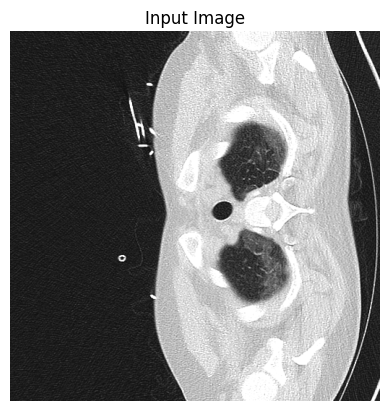

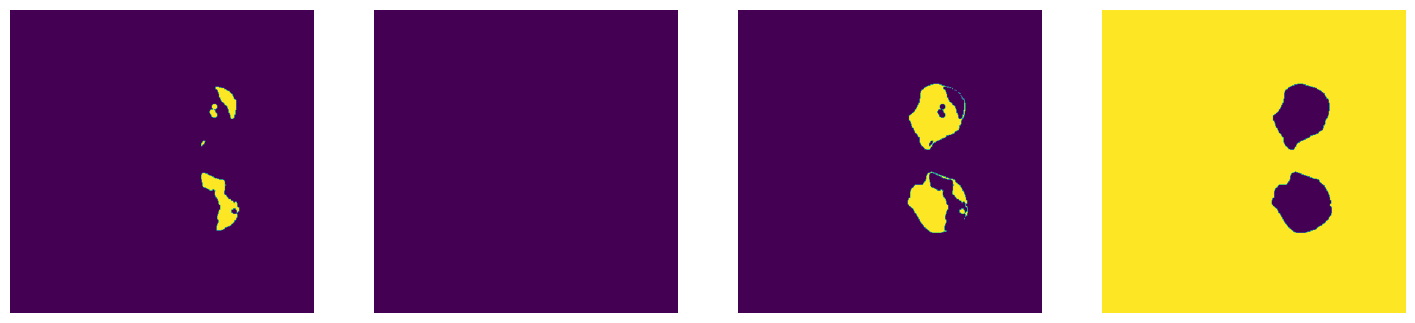

In [4]:
plt.figure()
plt.axis("off")
plt.imshow(train_imgs[145], cmap='gray')
plt.title("Input Image")

plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(141 + i)
    plt.axis("off")
    plt.imshow(train_masks[145, :, :, i])
    print(train_masks[145, :, :, i].min(), train_masks[145, :, :, i].max())

In [5]:
# Load pretrained model and preprocessing function
checkpoint = "smp-hub/segformer-b4-512x512-ade-160k"
model = smp.from_pretrained(checkpoint, classes=4, strict=False).eval().to(device)
preprocessing = A.Compose.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/257M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/segmentation_models_pytorch/base/model.py:137: UserWarning: 

 !!!!!! Mismatched keys !!!!!!

You should TRAIN the model to use it:
 - segmentation_head.0.weight: torch.Size([150, 768, 1, 1]) (weights) -> torch.Size([4, 768, 1, 1]) (model)
 - segmentation_head.0.bias: torch.Size([150]) (weights) -> torch.Size([4]) (model)

  warnings.warn(text, stacklevel=-1)


albumentations_config_eval.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

In [6]:
img = train_imgs[0][:, :, 0]
img = np.stack([img, img, img], axis=-1)
img.shape

(512, 512, 3)

In [7]:
class LungSegDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        
    def __getitem__(self, idx):
        img = self.imgs[idx][:, :, 0]
        mask = self.masks[idx]

        img = np.clip(img, -1500, 500) # Lung region
        img = (img + 1500) / 2000  # Normalize to [0,1]

        img = np.stack([img, img, img], axis=-1)
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        return img, mask
    
    def __len__(self):
        return len(self.imgs)

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
from torch.utils.data import DataLoader

train_dataset = LungSegDataset(train_imgs, train_masks, train_transform)
val_dataset = LungSegDataset(val_imgs, val_masks, val_transform)


train_loader = DataLoader(train_dataset, 8, shuffle=True)
val_loader = DataLoader(val_dataset, 8, shuffle=True)

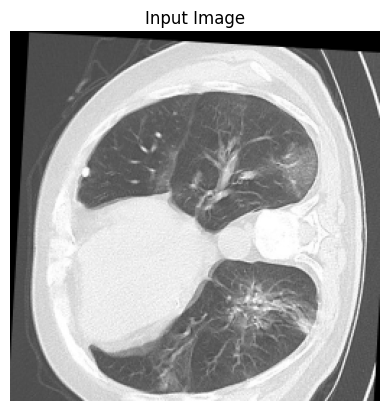

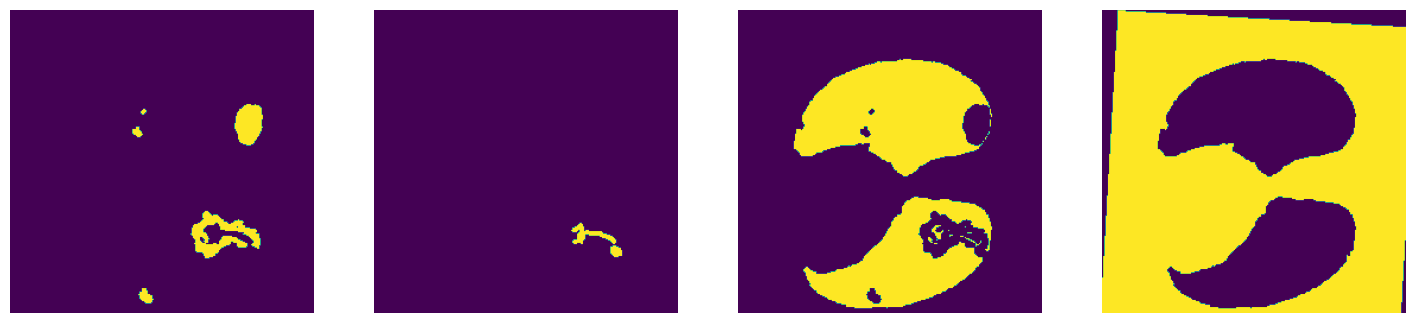

In [10]:
img, mask = train_dataset[20]

img = img[0]

plt.figure()
plt.axis("off")
plt.imshow(img, cmap='gray')
plt.title("Input Image")

plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(141 + i)
    plt.axis("off")
    plt.imshow(mask[:, :, i])

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
torch.cuda.empty_cache()

In [13]:
from torchmetrics.classification import MulticlassJaccardIndex
from tqdm import tqdm


for epoch in range(100):
    model.train()

    metric = MulticlassJaccardIndex(num_classes=4, average="macro").to(device)
    train_loss = 0 
    
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.cuda(), masks.cuda().float()

        optimizer.zero_grad()

        
        out = model(imgs).permute(0, 2, 3, 1)
        preds = out.argmax(dim=-1)  # get predicted class per pixel
        # masks = masks.argmax(dim=-1)
        
        # print(preds.shape, masks.shape) 
        metric.update(preds, masks.argmax(dim=-1))
        
        loss = loss_fn(out, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    miou = metric.compute().item()
    train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}: train loss: {train_loss}, mean IoU:{miou}')

100%|██████████| 104/104 [02:29<00:00,  1.43s/it]


Epoch 1: train loss: 334.54863768357495, mean IoU:0.18887805938720703


100%|██████████| 104/104 [02:27<00:00,  1.41s/it]


Epoch 2: train loss: 328.5210333604079, mean IoU:0.3398885428905487


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 3: train loss: 326.2190991915189, mean IoU:0.3923477530479431


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 4: train loss: 325.7147501431979, mean IoU:0.43707144260406494


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 5: train loss: 325.13349767831653, mean IoU:0.4673251211643219


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 6: train loss: 325.53756860586316, mean IoU:0.49282872676849365


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 7: train loss: 325.57262978186975, mean IoU:0.4798942804336548


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 8: train loss: 325.4363611661471, mean IoU:0.5152149796485901


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 9: train loss: 324.4052118154672, mean IoU:0.5190194845199585


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 10: train loss: 324.1905015798715, mean IoU:0.49105381965637207


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 11: train loss: 325.3373738802396, mean IoU:0.5113964676856995


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 12: train loss: 325.0496051494892, mean IoU:0.5302521586418152


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 13: train loss: 324.94636858426605, mean IoU:0.5430189371109009


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 14: train loss: 324.2508929325984, mean IoU:0.5235985517501831


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 15: train loss: 325.0237508920523, mean IoU:0.5347687602043152


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 16: train loss: 325.03722939124475, mean IoU:0.5383560061454773


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 17: train loss: 324.070676950308, mean IoU:0.5397939682006836


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 18: train loss: 325.49579708392804, mean IoU:0.546033501625061


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 19: train loss: 324.70154571533203, mean IoU:0.541442334651947


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 20: train loss: 325.18731454702527, mean IoU:0.5349285006523132


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 21: train loss: 325.5507413423978, mean IoU:0.5337246656417847


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 22: train loss: 323.8767582820012, mean IoU:0.5441763997077942


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 23: train loss: 324.91837574885443, mean IoU:0.5462470054626465


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 24: train loss: 325.3159414438101, mean IoU:0.5568828582763672


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 25: train loss: 324.17037787804236, mean IoU:0.5606452226638794


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 26: train loss: 324.08584330632135, mean IoU:0.5479720830917358


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 27: train loss: 325.42418259840747, mean IoU:0.5519536733627319


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 28: train loss: 324.68009596604566, mean IoU:0.5544498562812805


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 29: train loss: 323.3486501253568, mean IoU:0.5575004816055298


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 30: train loss: 325.16910670353815, mean IoU:0.5565838813781738


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 31: train loss: 325.65758044903095, mean IoU:0.5585753917694092


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 32: train loss: 325.4360196040227, mean IoU:0.5479472875595093


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 33: train loss: 324.37506338266223, mean IoU:0.5472404956817627


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 34: train loss: 323.84108235285834, mean IoU:0.5653210878372192


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 35: train loss: 324.1618681687575, mean IoU:0.5640591382980347


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 36: train loss: 324.7164250887357, mean IoU:0.5653325319290161


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 37: train loss: 324.7923856881949, mean IoU:0.561069905757904


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 38: train loss: 325.27406985943134, mean IoU:0.5456641912460327


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 39: train loss: 324.6981415381798, mean IoU:0.5658053159713745


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 40: train loss: 324.74286886361926, mean IoU:0.5786976218223572


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 41: train loss: 324.12004764263446, mean IoU:0.5678422451019287


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 42: train loss: 323.81207510141223, mean IoU:0.5667255520820618


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 43: train loss: 324.9264758183406, mean IoU:0.5748751163482666


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 44: train loss: 324.95732263418347, mean IoU:0.5797598361968994


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 45: train loss: 323.8761479304387, mean IoU:0.5718399286270142


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 46: train loss: 325.2315688500038, mean IoU:0.5781447291374207


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 47: train loss: 323.3646524869479, mean IoU:0.6094897985458374


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 48: train loss: 324.6927534250113, mean IoU:0.5958791971206665


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 49: train loss: 324.29444855910083, mean IoU:0.589763879776001


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 50: train loss: 325.284236907959, mean IoU:0.5947266817092896


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 51: train loss: 324.4260139465332, mean IoU:0.6002427339553833


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 52: train loss: 324.152223440317, mean IoU:0.5971794724464417


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 53: train loss: 325.0256450359638, mean IoU:0.5948781371116638


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 54: train loss: 325.15932259192834, mean IoU:0.5070573091506958


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 55: train loss: 325.6810825054462, mean IoU:0.5809038877487183


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 56: train loss: 324.4052951519306, mean IoU:0.6012647151947021


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 57: train loss: 324.3598283620981, mean IoU:0.6015288829803467


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 58: train loss: 324.0256761404184, mean IoU:0.6144380569458008


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 59: train loss: 324.8889562166654, mean IoU:0.6113573312759399


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 60: train loss: 324.2884938166692, mean IoU:0.6099031567573547


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 61: train loss: 324.4397415748009, mean IoU:0.6184210181236267


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 62: train loss: 323.4703756479117, mean IoU:0.6199753284454346


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 63: train loss: 325.068065056434, mean IoU:0.627240777015686


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 64: train loss: 323.0702059819148, mean IoU:0.619885265827179


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 65: train loss: 324.6881848848783, mean IoU:0.6199876666069031


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 66: train loss: 323.86622854379505, mean IoU:0.62027508020401


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 67: train loss: 323.9744638296274, mean IoU:0.6234161853790283


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 68: train loss: 323.98809638390173, mean IoU:0.633330225944519


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 69: train loss: 324.5293036240798, mean IoU:0.6285027265548706


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 70: train loss: 323.83396911621094, mean IoU:0.6241594552993774


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 71: train loss: 324.12308326134314, mean IoU:0.629408597946167


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 72: train loss: 324.8772248488206, mean IoU:0.6228882074356079


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 73: train loss: 323.98682432908276, mean IoU:0.631702721118927


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 74: train loss: 322.8446790255033, mean IoU:0.6375402212142944


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 75: train loss: 324.10420432457556, mean IoU:0.6345822811126709


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 76: train loss: 325.3970821087177, mean IoU:0.6405360698699951


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 77: train loss: 324.59106093186597, mean IoU:0.6104068160057068


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 78: train loss: 324.605951162485, mean IoU:0.6107832193374634


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 79: train loss: 324.0083753145658, mean IoU:0.6048928499221802


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 80: train loss: 325.2713376558744, mean IoU:0.6307961940765381


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 81: train loss: 324.4934202340933, mean IoU:0.639640212059021


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 82: train loss: 324.9742144071139, mean IoU:0.6380434036254883


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 83: train loss: 323.88393930288464, mean IoU:0.6387161016464233


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 84: train loss: 324.23902717003455, mean IoU:0.6401971578598022


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 85: train loss: 324.2516473623422, mean IoU:0.6389285326004028


100%|██████████| 104/104 [02:27<00:00,  1.41s/it]


Epoch 86: train loss: 324.33831933828503, mean IoU:0.6455016136169434


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 87: train loss: 324.91507251446063, mean IoU:0.6512259244918823


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 88: train loss: 323.6834584749662, mean IoU:0.6404212713241577


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 89: train loss: 324.0915665259728, mean IoU:0.6410316228866577


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 90: train loss: 324.65255825336163, mean IoU:0.6499683856964111


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 91: train loss: 324.27572044959436, mean IoU:0.6636288166046143


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 92: train loss: 325.135628920335, mean IoU:0.6670714020729065


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 93: train loss: 324.9133655841534, mean IoU:0.6735105514526367


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 94: train loss: 324.4092457111065, mean IoU:0.666292130947113


100%|██████████| 104/104 [02:26<00:00,  1.40s/it]


Epoch 95: train loss: 324.7196951646071, mean IoU:0.6614022850990295


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 96: train loss: 323.7148205683782, mean IoU:0.6520963907241821


100%|██████████| 104/104 [02:25<00:00,  1.40s/it]


Epoch 97: train loss: 324.0171626164363, mean IoU:0.6570241451263428


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 98: train loss: 323.7068815964919, mean IoU:0.6558212637901306


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]


Epoch 99: train loss: 323.5526706988995, mean IoU:0.6550123691558838


100%|██████████| 104/104 [02:26<00:00,  1.41s/it]

Epoch 100: train loss: 324.6856272770808, mean IoU:0.6660566329956055


In [14]:
# Setup metric
miou_metric = MulticlassJaccardIndex(num_classes=4, average="macro").to(device)

# In validation loop
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Predictions
        preds = model(imgs)  # [B, 4, H, W]

        # Convert both to class indices
        preds = preds.argmax(dim=1)  # [B, H, W]
        masks = masks.argmax(dim=-1)  # [B, H, W]

        # Update metric
        miou_metric.update(preds, masks)

# After all batches
mean_iou = miou_metric.compute().item()
print(f"Validation Mean IoU: {mean_iou:.4f}")

Validation Mean IoU: 0.6114


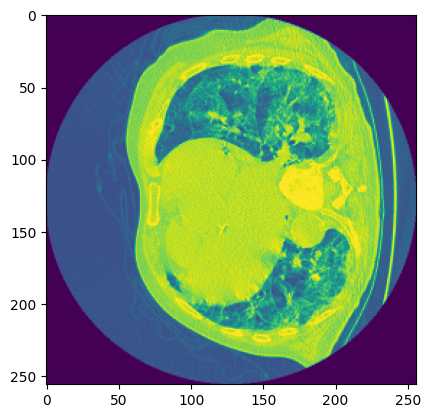

torch.Size([3, 256, 256])
torch.Size([256, 256, 4]) torch.Size([256, 256, 4])


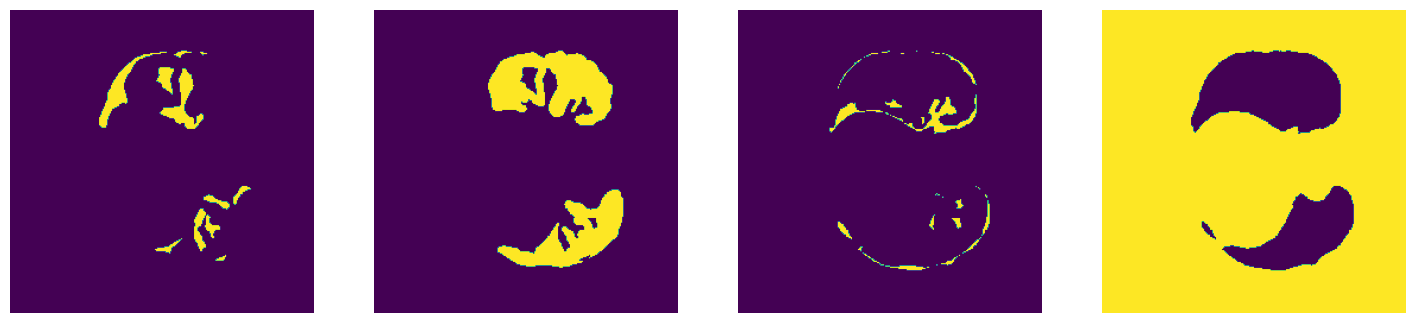

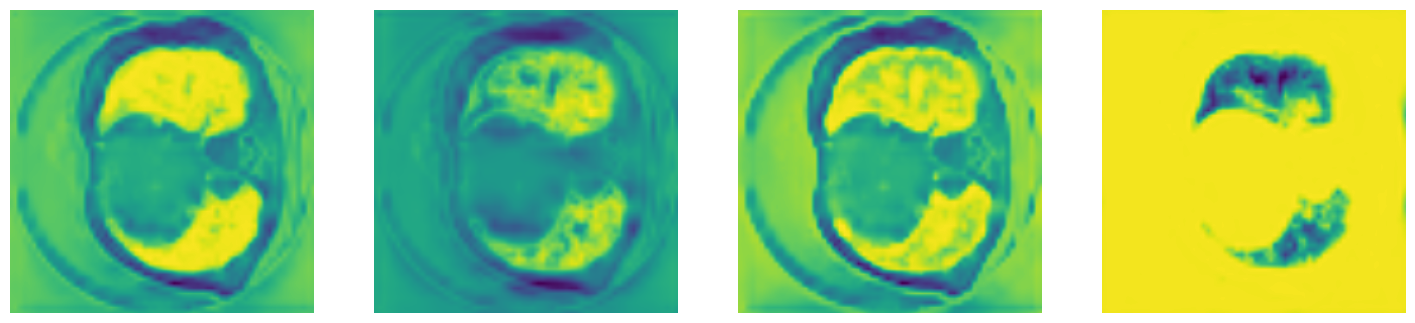

In [15]:
img, mask = val_dataset[0]

img = img[0]

plt.imshow(img)
plt.show()

img = torch.tensor(np.stack([img, img, img], axis=0))

print(img.shape)

# Predictions
model.eval()
model.to('cpu')
with torch.no_grad():
    preds = model(img.unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu()  # [B, 4, H, W]
    
    print(preds.shape, mask.shape)
    plt.figure(figsize=(18, 6))
    for i in range(4):
        plt.subplot(141 + i)
        plt.axis("off")
        plt.imshow(mask[:, :, i])
    plt.show()
    
    plt.figure(figsize=(18, 6))
    for i in range(4):
        plt.subplot(141 + i)
        plt.axis("off")
        plt.imshow(preds[:, :, i])